In [2]:
#import statements
import compy.ode as ode 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

In [3]:
import anvil.server

anvil.server.connect("FMHSYAIF3GNIAEBKKDDF5UWK-AIFJWQ4GEWC47KA7")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment (dev)" as SERVER


In [6]:
@anvil.server.callable
def create_model_earth(launchangle,launchspeed,spinrate):
    
    #Quality of Life Functions
    def mag(v):
        #calculate magnitude of an array
        return np.sqrt(np.dot(v,v))

    def hat(v):
        #calculate unit vector of an array
        return v/mag(v)

    def cross(v1,v2):
        #calculate the cross product of two vectors
        return np.cross(v1,v2)
    
    #Function to change Cd during trajectory calculations
    def getCd(v):
    # calculate value of drag coefficient for a particular speed and case
    
        if case == 0:
            Cd = 0
        elif case == 1:
            Cd = 0.7
        elif case == 2:
            a = 0.36
            b = 0.14
            c = 0.27
            vc = 34
            chi = (v - vc)/4
            if chi < 0:
                Cd = a + b/(1+np.exp(chi)) - c*np.exp(-chi**2)
            else:
                Cd = a + b/(1+np.exp(chi)) - c*np.exp(-chi**2/4)
        else:
            Cd = 0.7
    
        return Cd
    
    
    #Function to model our trajectory array with Magnus Effect before running the simulation.
    def model_magnus(d, tn):
        #return array of derivatives
        
        #data
        x = d[0]
        y = d[1]
        z = d[2]  
        vx = d[3]
        vy = d[4]
        vz = d[5]
    
        #derivatives
    
        rate = np.zeros(6) #derivatives
        rate[0] = vx
        rate[1] = vy
        rate[2] = vz
    
        #speed
        v = np.array([vx,vy,vz])
        vmag = mag(v)
    
        #calculate force and dv/dt
        Cd=getCd(vmag)
        b2 = 1/2*Cd*rho*A
    
        S = r*omegamag/vmag
        CL = 0.62*S**0.7
        alpha = 1/2*CL*rho*A*r/S
    
        FM = alpha*cross(omega,v) #magnus force
    
        rate[3] = -b2*vmag*vx/m + FM[0]/m
        rate[4] = (-b2*vmag*vy - m*g)/m + FM[1]/m
        rate[5] = (-b2*vmag*vz)/m  + FM[2]/m
    
        return rate
    
    #simulation with magnus effect
    def run_magnus(data): # run simulation with case integer
        global b2, alpha #need to change the value of b2 and alpha
    
        v = data[3:6]
        vmag = mag(v)

        #time
        t = 0
        h= 0.01
        Nsteps = int(60/h) #simulation goes for 60 seconds

        #store trajectory for plotting or animation
        traj = np.zeros((Nsteps, 4)) #store t, x, y, z for plotting
        traj[0,:] = np.array([t, x0, y0, z0]) #store initial time and position

        for n in range(0,Nsteps-1):

            #update data
            data = ode.RK4(model_magnus, data, t, h )

            #update t
            t = t + h
            
            #store data for plotting
            traj[n+1,:] = np.array([t, data[0], data[1], data[2]])
    
        return traj
    
    #indepdent variables
    m = 20 #mass of mortar(kg)
    g = 9.8 #N/kg gravity by earth
    Cd = 0.7 #drag coefficeint for mortar
    r = (81e-3)/2 #81 mm radius for presicion mortar
    A = np.pi*r**2 #area of mortar 
    rho = 1.2 #kg/m^3
    b2 = 1/2*Cd*rho*A #drag with wind resistance
    S = 0.01 #value will change as omega and v change
    CL = 0 #value will change with S
    alpha = 1/2*CL*rho*A*r/S 
    
    #conversions for input -- uses launchangle & launchspeed
    theta0 = int(launchangle)*(np.pi/180)
    vmag0 = int(launchspeed) * 0.44704
    
    #dependent variables
    x0 = 0 #initial x pos of mortar
    vx0 = vmag0*np.cos(theta0) #initial x vel of mortar
    y0 = 0 #y pos of mortar during initial launch
    vy0 = vmag0*np.sin(theta0)
    z0 = 0
    vz0 = 0
    
    #omega -- uses spinrate
    omegamag = int(spinrate)*2*np.pi/60
    omega = np.array([0,0,omegamag])
    
    #array for velocity and position data
    d = np.array([x0,y0,z0,vx0,vy0,vz0]) #initialize dependent variables
    
    #run models
    case = 0 #no air
    traj = run_magnus(d)
    traj0 = traj[traj[:,2]>=0] #get trajectory data with y>=0

    case = 1 #Cd is constant
    traj = run_magnus(d)
    traj1 = traj[traj[:,2]>=0] #get trajectory data with y>=0

    case = 2
    traj = run_magnus(d)
    traj2 = traj[traj[:,2]>=0] #get trajectory data with y>=0
    
    #plot data
    fig = plt.figure(figsize=(12,6))
    plt.title("Mortar Trajectory with Magnus Effect on Earth")
    plt.plot(traj0[:,1], traj0[:,2], 'b.', label='$C_d=0$')
    plt.plot(traj1[:,1], traj1[:,2], 'g.', label='$C_d=0.5$')
    plt.plot(traj2[:,1], traj2[:,2], 'c.', label='speed-dependent $C_d$')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.legend()
    #plt.savefig("trajplot.png",bbox_inches ="tight",facecolor ="w",pad_inches = 1,orientation ='landscape')
    plt.show()
    
    range0 = traj0[-1,1]
    range1 = traj1[-1,1]
    range2 = traj2[-1,1]

    print("Cd=0: range = {:.0f} m = {:.0f} ft. ".format(range0, range0*3.28084))
    print("Cd=5: range = {:.0f} m = {:.0f} ft. ".format(range1, range1*3.28084))
    print("Variable Cd: range = {:.0f} m = {:.0f} ft. ".format(range2, range2*3.28084))

In [7]:
@anvil.server.callable
def create_model_tuchanka(launchangle,launchspeed,spinrate):
    
    #Quality of Life Functions
    def mag(v):
        #calculate magnitude of an array
        return np.sqrt(np.dot(v,v))

    def hat(v):
        #calculate unit vector of an array
        return v/mag(v)

    def cross(v1,v2):
        #calculate the cross product of two vectors
        return np.cross(v1,v2)
    
    #Function to change Cd during trajectory calculations
    def getCd(v):
    # calculate value of drag coefficient for a particular speed and case
    
        if case == 0:
            Cd = 0
        elif case == 1:
            Cd = 0.7
        elif case == 2:
            a = 0.36
            b = 0.14
            c = 0.27
            vc = 34
            chi = (v - vc)/4
            if chi < 0:
                Cd = a + b/(1+np.exp(chi)) - c*np.exp(-chi**2)
            else:
                Cd = a + b/(1+np.exp(chi)) - c*np.exp(-chi**2/4)
        else:
            Cd = 0.7
    
        return Cd
    
    
    #Function to model our trajectory array with Magnus Effect before running the simulation.
    def model_magnus(d, tn):
        #return array of derivatives
        
        #data
        x = d[0]
        y = d[1]
        z = d[2]  
        vx = d[3]
        vy = d[4]
        vz = d[5]
    
        #derivatives
    
        rate = np.zeros(6) #derivatives
        rate[0] = vx
        rate[1] = vy
        rate[2] = vz
    
        #speed
        v = np.array([vx,vy,vz])
        vmag = mag(v)
    
        #calculate force and dv/dt
        Cd=getCd(vmag)
        b2 = 1/2*Cd*rho_tuc*A
    
        S = r*omegamag/vmag
        CL = 0.62*S**0.7
        alpha = 1/2*CL*rho_tuc*A*r/S
    
        FM = alpha*cross(omega,v) #magnus force
    
        rate[3] = -b2*vmag*vx/m + FM[0]/m
        rate[4] = (-b2*vmag*vy - m*g_tuc)/m + FM[1]/m
        rate[5] = (-b2*vmag*vz)/m  + FM[2]/m
    
        return rate
    
    #simulation with magnus effect
    def run_magnus(data): # run simulation with case integer
        global b2, alpha_tuc #need to change the value of b2 and alpha
    
        v = data[3:6]
        vmag = mag(v)

        #time
        t = 0
        h= 0.01
        Nsteps = int(60/h) #simulation goes for 60 seconds

        #store trajectory for plotting or animation
        traj = np.zeros((Nsteps, 4)) #store t, x, y, z for plotting
        traj[0,:] = np.array([t, x0, y0, z0]) #store initial time and position

        for n in range(0,Nsteps-1):

            #update data
            data = ode.RK4(model_magnus, data, t, h )

            #update t
            t = t + h
            
            #store data for plotting
            traj[n+1,:] = np.array([t, data[0], data[1], data[2]])
    
        return traj
    
    #indepdent variables
    m = 20 #mass of mortar(kg)
    g = 9.8 #N/kg gravity by earth
    g_tuc = g*1.14 #N/kg gravity by Tuchanka
    Cd = 0.7 #drag coefficeint for mortar
    r = (81e-3)/2 #81 mm radius for presicion mortar
    A = np.pi*r**2 #area of mortar 
    rho = 1.2 #kg/m^3
    rho_tuc = 1.12497 #kg/m^3 air density on Tuchanka
    b2 = 1/2*Cd*rho*A #drag with wind resistance
    b2_tuc = 1/2*Cd*rho_tuc*A #drag w/ Tuchanka wind resistance
    S = 0.01 #value will change as omega and v change
    CL = 0 #value will change with S
    alpha = 1/2*CL*rho*A*r/S 
    alpha_tuc = 1/2*CL*rho_tuc*A*r/S #alpha on Tuchanka
    
    #conversions for input -- uses launchangle & launchspeed
    theta0 = int(launchangle)*(np.pi/180)
    vmag0 = int(launchspeed) * 0.44704
    
    #dependent variables
    x0 = 0 #initial x pos of mortar
    vx0 = vmag0*np.cos(theta0) #initial x vel of mortar
    y0 = 0 #y pos of mortar during initial launch
    vy0 = vmag0*np.sin(theta0)
    z0 = 0
    vz0 = 0
    
    #omega -- uses spinrate
    omegamag = int(spinrate)*2*np.pi/60
    omega = np.array([0,0,omegamag])
    
    #array for velocity and position data
    d = np.array([x0,y0,z0,vx0,vy0,vz0]) #initialize dependent variables
    
    #run models
    case = 0 #no air
    traj = run_magnus(d)
    traj0 = traj[traj[:,2]>=0] #get trajectory data with y>=0

    case = 1 #Cd is constant
    traj = run_magnus(d)
    traj1 = traj[traj[:,2]>=0] #get trajectory data with y>=0

    case = 2
    traj = run_magnus(d)
    traj2 = traj[traj[:,2]>=0] #get trajectory data with y>=0
    
    #plot data
    fig = plt.figure(figsize=(12,6))
    plt.title("Mortar Trajectory with Magnus Effect on Tuchanka")
    plt.plot(traj0[:,1], traj0[:,2], 'g.', label='$C_d=0$')
    plt.plot(traj1[:,1], traj1[:,2], 'm.', label='$C_d=0.5$')
    plt.plot(traj2[:,1], traj2[:,2], 'r.', label='speed-dependent $C_d$')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.legend()
    #plt.savefig("trajplot.png",bbox_inches ="tight",facecolor ="w",pad_inches = 1,orientation ='landscape')
    plt.show()
    
    range0 = traj0[-1,1]
    range1 = traj1[-1,1]
    range2 = traj2[-1,1]

    print("Cd=0: range = {:.0f} m = {:.0f} ft. ".format(range0, range0*3.28084))
    print("Cd=5: range = {:.0f} m = {:.0f} ft. ".format(range1, range1*3.28084))
    print("Variable Cd: range = {:.0f} m = {:.0f} ft. ".format(range2, range2*3.28084))

In [12]:
@anvil.server.callable
def create_model_palaven(launchangle,launchspeed,spinrate):
    
    #Quality of Life Functions
    def mag(v):
        #calculate magnitude of an array
        return np.sqrt(np.dot(v,v))

    def hat(v):
        #calculate unit vector of an array
        return v/mag(v)

    def cross(v1,v2):
        #calculate the cross product of two vectors
        return np.cross(v1,v2)
    
    #Function to change Cd during trajectory calculations
    def getCd(v):
    # calculate value of drag coefficient for a particular speed and case
    
        if case == 0:
            Cd = 0
        elif case == 1:
            Cd = 0.7
        elif case == 2:
            a = 0.36
            b = 0.14
            c = 0.27
            vc = 34
            chi = (v - vc)/4
            if chi < 0:
                Cd = a + b/(1+np.exp(chi)) - c*np.exp(-chi**2)
            else:
                Cd = a + b/(1+np.exp(chi)) - c*np.exp(-chi**2/4)
        else:
            Cd = 0.7
    
        return Cd
    
    
    #Function to model our trajectory array with Magnus Effect before running the simulation.
    def model_magnus(d, tn):
        #return array of derivatives
        
        #data
        x = d[0]
        y = d[1]
        z = d[2]  
        vx = d[3]
        vy = d[4]
        vz = d[5]
    
        #derivatives
    
        rate = np.zeros(6) #derivatives
        rate[0] = vx
        rate[1] = vy
        rate[2] = vz
    
        #speed
        v = np.array([vx,vy,vz])
        vmag = mag(v)
    
        #calculate force and dv/dt
        Cd=getCd(vmag)
        b2 = 1/2*Cd*rho_pal*A
    
        S = r*omegamag/vmag
        CL = 0.62*S**0.7
        alpha = 1/2*CL*rho_pal*A*r/S
    
        FM = alpha*cross(omega,v) #magnus force
    
        rate[3] = -b2*vmag*vx/m + FM[0]/m
        rate[4] = (-b2*vmag*vy - m*g_pal)/m + FM[1]/m
        rate[5] = (-b2*vmag*vz)/m  + FM[2]/m
    
        return rate
    
    #simulation with magnus effect
    def run_magnus(data): # run simulation with case integer
        global b2, alpha_pal #need to change the value of b2 and alpha
    
        v = data[3:6]
        vmag = mag(v)

        #time
        t = 0
        h= 0.01
        Nsteps = int(60/h) #simulation goes for 60 seconds

        #store trajectory for plotting or animation
        traj = np.zeros((Nsteps, 4)) #store t, x, y, z for plotting
        traj[0,:] = np.array([t, x0, y0, z0]) #store initial time and position

        for n in range(0,Nsteps-1):

            #update data
            data = ode.RK4(model_magnus, data, t, h )

            #update t
            t = t + h
            
            #store data for plotting
            traj[n+1,:] = np.array([t, data[0], data[1], data[2]])
    
        return traj
    
    #indepdent variables
    m = 20 #mass of mortar(kg)
    g = 9.8 #N/kg gravity by earth
    g_pal = g*1.14 #N/kg gravity by Palaven
    Cd = 0.7 #drag coefficeint for mortar
    r = (81e-3)/2 #81 mm radius for presicion mortar
    A = np.pi*r**2 #area of mortar 
    rho = 1.2 #kg/m^3
    rho_pal = 1.27661 #kg/m^3 air density on Palaven
    b2 = 1/2*Cd*rho*A #drag with wind resistance
    b2_pal = 1/2*Cd*rho_pal*A #drag w/ Palaven wind resistance
    S = 0.01 #value will change as omega and v change
    CL = 0 #value will change with S
    alpha = 1/2*CL*rho*A*r/S 
    alpha_pal = 1/2*CL*rho_pal*A*r/S #alpha on Palaven
    
    #conversions for input -- uses launchangle & launchspeed
    theta0 = int(launchangle)*(np.pi/180)
    vmag0 = int(launchspeed) * 0.44704
    
    #dependent variables
    x0 = 0 #initial x pos of mortar
    vx0 = vmag0*np.cos(theta0) #initial x vel of mortar
    y0 = 0 #y pos of mortar during initial launch
    vy0 = vmag0*np.sin(theta0)
    z0 = 0
    vz0 = 0
    
    #omega -- uses spinrate
    omegamag = int(spinrate)*2*np.pi/60
    omega = np.array([0,0,omegamag])
    
    #array for velocity and position data
    d = np.array([x0,y0,z0,vx0,vy0,vz0]) #initialize dependent variables
    
    #run models
    case = 0 #no air
    traj = run_magnus(d)
    traj0 = traj[traj[:,2]>=0] #get trajectory data with y>=0

    case = 1 #Cd is constant
    traj = run_magnus(d)
    traj1 = traj[traj[:,2]>=0] #get trajectory data with y>=0

    case = 2
    traj = run_magnus(d)
    traj2 = traj[traj[:,2]>=0] #get trajectory data with y>=0
    
    #plot data
    fig = plt.figure(figsize=(12,6))
    plt.title("Mortar Trajectory with Magnus Effect on Palaven")
    plt.plot(traj0[:,1], traj0[:,2], 'b.', label='$C_d=0$')
    plt.plot(traj1[:,1], traj1[:,2], 'm.', label='$C_d=0.5$')
    plt.plot(traj2[:,1], traj2[:,2], 'r.', label='speed-dependent $C_d$')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.legend()
    #plt.savefig("trajplot.png",bbox_inches ="tight",facecolor ="w",pad_inches = 1,orientation ='landscape')
    plt.show()
    
    range0 = traj0[-1,1]
    range1 = traj1[-1,1]
    range2 = traj2[-1,1]

    print("Cd=0: range = {:.0f} m = {:.0f} ft. ".format(range0, range0*3.28084))
    print("Cd=5: range = {:.0f} m = {:.0f} ft. ".format(range1, range1*3.28084))
    print("Variable Cd: range = {:.0f} m = {:.0f} ft. ".format(range2, range2*3.28084))

In [11]:
@anvil.server.callable
def create_model_surkesh(launchangle,launchspeed,spinrate):
    
    #Quality of Life Functions
    def mag(v):
        #calculate magnitude of an array
        return np.sqrt(np.dot(v,v))

    def hat(v):
        #calculate unit vector of an array
        return v/mag(v)

    def cross(v1,v2):
        #calculate the cross product of two vectors
        return np.cross(v1,v2)
    
    #Function to change Cd during trajectory calculations
    def getCd(v):
    # calculate value of drag coefficient for a particular speed and case
    
        if case == 0:
            Cd = 0
        elif case == 1:
            Cd = 0.7
        elif case == 2:
            a = 0.36
            b = 0.14
            c = 0.27
            vc = 34
            chi = (v - vc)/4
            if chi < 0:
                Cd = a + b/(1+np.exp(chi)) - c*np.exp(-chi**2)
            else:
                Cd = a + b/(1+np.exp(chi)) - c*np.exp(-chi**2/4)
        else:
            Cd = 0.7
    
        return Cd
    
    
    #Function to model our trajectory array with Magnus Effect before running the simulation.
    def model_magnus(d, tn):
        #return array of derivatives
        
        #data
        x = d[0]
        y = d[1]
        z = d[2]  
        vx = d[3]
        vy = d[4]
        vz = d[5]
    
        #derivatives
    
        rate = np.zeros(6) #derivatives
        rate[0] = vx
        rate[1] = vy
        rate[2] = vz
    
        #speed
        v = np.array([vx,vy,vz])
        vmag = mag(v)
    
        #calculate force and dv/dt
        Cd=getCd(vmag)
        b2 = 1/2*Cd*rho_sur*A
    
        S = r*omegamag/vmag
        CL = 0.62*S**0.7
        alpha = 1/2*CL*rho_sur*A*r/S
    
        FM = alpha*cross(omega,v) #magnus force
    
        rate[3] = -b2*vmag*vx/m + FM[0]/m
        rate[4] = (-b2*vmag*vy - m*g_sur)/m + FM[1]/m
        rate[5] = (-b2*vmag*vz)/m  + FM[2]/m
    
        return rate
    
    #simulation with magnus effect
    def run_magnus(data): # run simulation with case integer
        global b2, alpha_sur #need to change the value of b2 and alpha
    
        v = data[3:6]
        vmag = mag(v)

        #time
        t = 0
        h= 0.01
        Nsteps = int(60/h) #simulation goes for 60 seconds

        #store trajectory for plotting or animation
        traj = np.zeros((Nsteps, 4)) #store t, x, y, z for plotting
        traj[0,:] = np.array([t, x0, y0, z0]) #store initial time and position

        for n in range(0,Nsteps-1):

            #update data
            data = ode.RK4(model_magnus, data, t, h )

            #update t
            t = t + h
            
            #store data for plotting
            traj[n+1,:] = np.array([t, data[0], data[1], data[2]])
    
        return traj
    
    #indepdent variables
    m = 20 #mass of mortar(kg)
    g = 9.8 #N/kg gravity by earth
    g_sur = g*0.94 #N/kg gravity by Sur'Kesh
    Cd = 0.7 #drag coefficeint for mortar
    r = (81e-3)/2 #81 mm radius for presicion mortar
    A = np.pi*r**2 #area of mortar 
    rho = 1.2 #kg/m^3
    rho_sur = 1.68116 #kg/m^3 air density on Sur'Kesh
    b2 = 1/2*Cd*rho*A #drag with wind resistance
    b2_sur = 1/2*Cd*rho_sur*A #drag w/ Sur'Kesh wind resistance
    S = 0.01 #value will change as omega and v change
    CL = 0 #value will change with S
    alpha = 1/2*CL*rho*A*r/S 
    alpha_sur = 1/2*CL*rho_sur*A*r/S #alpha on Sur'Kesh
    
    #conversions for input -- uses launchangle & launchspeed
    theta0 = int(launchangle)*(np.pi/180)
    vmag0 = int(launchspeed) * 0.44704
    
    #dependent variables
    x0 = 0 #initial x pos of mortar
    vx0 = vmag0*np.cos(theta0) #initial x vel of mortar
    y0 = 0 #y pos of mortar during initial launch
    vy0 = vmag0*np.sin(theta0)
    z0 = 0
    vz0 = 0
    
    #omega -- uses spinrate
    omegamag = int(spinrate)*2*np.pi/60
    omega = np.array([0,0,omegamag])
    
    #array for velocity and position data
    d = np.array([x0,y0,z0,vx0,vy0,vz0]) #initialize dependent variables
    
    #run models
    case = 0 #no air
    traj = run_magnus(d)
    traj0 = traj[traj[:,2]>=0] #get trajectory data with y>=0

    case = 1 #Cd is constant
    traj = run_magnus(d)
    traj1 = traj[traj[:,2]>=0] #get trajectory data with y>=0

    case = 2
    traj = run_magnus(d)
    traj2 = traj[traj[:,2]>=0] #get trajectory data with y>=0
    
    #plot data
    fig = plt.figure(figsize=(12,6))
    plt.title("Mortar Trajectory with Magnus Effect on Sur'Kesh")
    plt.plot(traj0[:,1], traj0[:,2], 'b.', label='$C_d=0$')
    plt.plot(traj1[:,1], traj1[:,2], 'm.', label='$C_d=0.5$')
    plt.plot(traj2[:,1], traj2[:,2], 'r.', label='speed-dependent $C_d$')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.legend()
    #plt.savefig("trajplot.png",bbox_inches ="tight",facecolor ="w",pad_inches = 1,orientation ='landscape')
    plt.show()
    
    range0 = traj0[-1,1]
    range1 = traj1[-1,1]
    range2 = traj2[-1,1]

    print("Cd=0: range = {:.0f} m = {:.0f} ft. ".format(range0, range0*3.28084))
    print("Cd=5: range = {:.0f} m = {:.0f} ft. ".format(range1, range1*3.28084))
    print("Variable Cd: range = {:.0f} m = {:.0f} ft. ".format(range2, range2*3.28084))

In [14]:
@anvil.server.callable
def create_model_rannoch(launchangle,launchspeed,spinrate):
    
    #Quality of Life Functions
    def mag(v):
        #calculate magnitude of an array
        return np.sqrt(np.dot(v,v))

    def hat(v):
        #calculate unit vector of an array
        return v/mag(v)

    def cross(v1,v2):
        #calculate the cross product of two vectors
        return np.cross(v1,v2)
    
    #Function to change Cd during trajectory calculations
    def getCd(v):
    # calculate value of drag coefficient for a particular speed and case
    
        if case == 0:
            Cd = 0
        elif case == 1:
            Cd = 0.7
        elif case == 2:
            a = 0.36
            b = 0.14
            c = 0.27
            vc = 34
            chi = (v - vc)/4
            if chi < 0:
                Cd = a + b/(1+np.exp(chi)) - c*np.exp(-chi**2)
            else:
                Cd = a + b/(1+np.exp(chi)) - c*np.exp(-chi**2/4)
        else:
            Cd = 0.7
    
        return Cd
    
    
    #Function to model our trajectory array with Magnus Effect before running the simulation.
    def model_magnus(d, tn):
        #return array of derivatives
        
        #data
        x = d[0]
        y = d[1]
        z = d[2]  
        vx = d[3]
        vy = d[4]
        vz = d[5]
    
        #derivatives
    
        rate = np.zeros(6) #derivatives
        rate[0] = vx
        rate[1] = vy
        rate[2] = vz
    
        #speed
        v = np.array([vx,vy,vz])
        vmag = mag(v)
    
        #calculate force and dv/dt
        Cd=getCd(vmag)
        b2 = 1/2*Cd*rho_ran*A
    
        S = r*omegamag/vmag
        CL = 0.62*S**0.7
        alpha = 1/2*CL*rho_ran*A*r/S
    
        FM = alpha*cross(omega,v) #magnus force
    
        rate[3] = -b2*vmag*vx/m + FM[0]/m
        rate[4] = (-b2*vmag*vy - m*g_ran)/m + FM[1]/m
        rate[5] = (-b2*vmag*vz)/m  + FM[2]/m
    
        return rate
    
    #simulation with magnus effect
    def run_magnus(data): # run simulation with case integer
        global b2, alpha_ran #need to change the value of b2 and alpha
    
        v = data[3:6]
        vmag = mag(v)

        #time
        t = 0
        h= 0.01
        Nsteps = int(60/h) #simulation goes for 60 seconds

        #store trajectory for plotting or animation
        traj = np.zeros((Nsteps, 4)) #store t, x, y, z for plotting
        traj[0,:] = np.array([t, x0, y0, z0]) #store initial time and position

        for n in range(0,Nsteps-1):

            #update data
            data = ode.RK4(model_magnus, data, t, h )

            #update t
            t = t + h
            
            #store data for plotting
            traj[n+1,:] = np.array([t, data[0], data[1], data[2]])
    
        return traj
    
    #indepdent variables
    m = 20 #mass of mortar(kg)
    g = 9.8 #N/kg gravity by earth
    g_ran = g*0.89 #N/kg gravity by Rannoch
    Cd = 0.7 #drag coefficeint for mortar
    r = (81e-3)/2 #81 mm radius for presicion mortar
    A = np.pi*r**2 #area of mortar 
    rho = 1.2 #kg/m^3
    rho_ran = 1.02218 #kg/m^3 air density on Rannoch
    b2 = 1/2*Cd*rho*A #drag with wind resistance
    b2_ran = 1/2*Cd*rho_ran*A #drag w/ Rannoch wind resistance
    S = 0.01 #value will change as omega and v change
    CL = 0 #value will change with S
    alpha = 1/2*CL*rho*A*r/S 
    alpha_ran = 1/2*CL*rho_ran*A*r/S #alpha on Rannoch
    
    #conversions for input -- uses launchangle & launchspeed
    theta0 = int(launchangle)*(np.pi/180)
    vmag0 = int(launchspeed) * 0.44704
    
    #dependent variables
    x0 = 0 #initial x pos of mortar
    vx0 = vmag0*np.cos(theta0) #initial x vel of mortar
    y0 = 0 #y pos of mortar during initial launch
    vy0 = vmag0*np.sin(theta0)
    z0 = 0
    vz0 = 0
    
    #omega -- uses spinrate
    omegamag = int(spinrate)*2*np.pi/60
    omega = np.array([0,0,omegamag])
    
    #array for velocity and position data
    d = np.array([x0,y0,z0,vx0,vy0,vz0]) #initialize dependent variables
    
    #run models
    case = 0 #no air
    traj = run_magnus(d)
    traj0 = traj[traj[:,2]>=0] #get trajectory data with y>=0

    case = 1 #Cd is constant
    traj = run_magnus(d)
    traj1 = traj[traj[:,2]>=0] #get trajectory data with y>=0

    case = 2
    traj = run_magnus(d)
    traj2 = traj[traj[:,2]>=0] #get trajectory data with y>=0
    
    #plot data
    fig = plt.figure(figsize=(12,6))
    plt.title("Mortar Trajectory with Magnus Effect on Rannoch")
    plt.plot(traj0[:,1], traj0[:,2], 'b.', label='$C_d=0$')
    plt.plot(traj1[:,1], traj1[:,2], 'm.', label='$C_d=0.5$')
    plt.plot(traj2[:,1], traj2[:,2], 'r.', label='speed-dependent $C_d$')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.legend()
    #plt.savefig("trajplot.png",bbox_inches ="tight",facecolor ="w",pad_inches = 1,orientation ='landscape')
    plt.show()
    
    range0 = traj0[-1,1]
    range1 = traj1[-1,1]
    range2 = traj2[-1,1]

    print("Cd=0: range = {:.0f} m = {:.0f} ft. ".format(range0, range0*3.28084))
    print("Cd=5: range = {:.0f} m = {:.0f} ft. ".format(range1, range1*3.28084))
    print("Variable Cd: range = {:.0f} m = {:.0f} ft. ".format(range2, range2*3.28084))

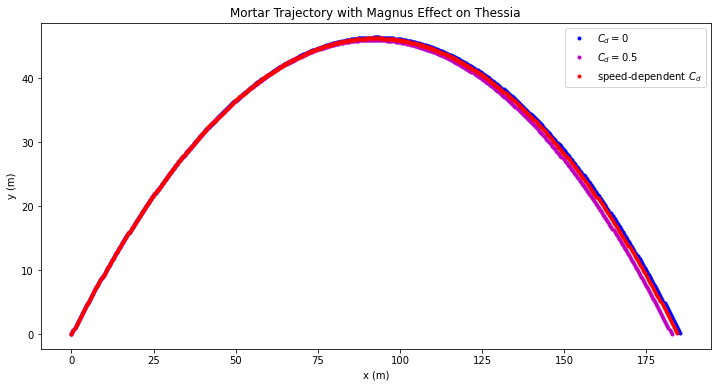

Cd=0: range = 185 m = 608 ft. 
Cd=5: range = 183 m = 599 ft. 
Variable Cd: range = 184 m = 605 ft. 


In [15]:
@anvil.server.callable
def create_model_thessia(launchangle,launchspeed,spinrate):
    
    #Quality of Life Functions
    def mag(v):
        #calculate magnitude of an array
        return np.sqrt(np.dot(v,v))

    def hat(v):
        #calculate unit vector of an array
        return v/mag(v)

    def cross(v1,v2):
        #calculate the cross product of two vectors
        return np.cross(v1,v2)
    
    #Function to change Cd during trajectory calculations
    def getCd(v):
    # calculate value of drag coefficient for a particular speed and case
    
        if case == 0:
            Cd = 0
        elif case == 1:
            Cd = 0.7
        elif case == 2:
            a = 0.36
            b = 0.14
            c = 0.27
            vc = 34
            chi = (v - vc)/4
            if chi < 0:
                Cd = a + b/(1+np.exp(chi)) - c*np.exp(-chi**2)
            else:
                Cd = a + b/(1+np.exp(chi)) - c*np.exp(-chi**2/4)
        else:
            Cd = 0.7
    
        return Cd
    
    
    #Function to model our trajectory array with Magnus Effect before running the simulation.
    def model_magnus(d, tn):
        #return array of derivatives
        
        #data
        x = d[0]
        y = d[1]
        z = d[2]  
        vx = d[3]
        vy = d[4]
        vz = d[5]
    
        #derivatives
    
        rate = np.zeros(6) #derivatives
        rate[0] = vx
        rate[1] = vy
        rate[2] = vz
    
        #speed
        v = np.array([vx,vy,vz])
        vmag = mag(v)
    
        #calculate force and dv/dt
        Cd=getCd(vmag)
        b2 = 1/2*Cd*rho_the*A
    
        S = r*omegamag/vmag
        CL = 0.62*S**0.7
        alpha = 1/2*CL*rho_the*A*r/S
    
        FM = alpha*cross(omega,v) #magnus force
    
        rate[3] = -b2*vmag*vx/m + FM[0]/m
        rate[4] = (-b2*vmag*vy - m*g_the)/m + FM[1]/m
        rate[5] = (-b2*vmag*vz)/m  + FM[2]/m
    
        return rate
    
    #simulation with magnus effect
    def run_magnus(data): # run simulation with case integer
        global b2, alpha_the #need to change the value of b2 and alpha
    
        v = data[3:6]
        vmag = mag(v)

        #time
        t = 0
        h= 0.01
        Nsteps = int(60/h) #simulation goes for 60 seconds

        #store trajectory for plotting or animation
        traj = np.zeros((Nsteps, 4)) #store t, x, y, z for plotting
        traj[0,:] = np.array([t, x0, y0, z0]) #store initial time and position

        for n in range(0,Nsteps-1):

            #update data
            data = ode.RK4(model_magnus, data, t, h )

            #update t
            t = t + h
            
            #store data for plotting
            traj[n+1,:] = np.array([t, data[0], data[1], data[2]])
    
        return traj
    
    #indepdent variables
    m = 20 #mass of mortar(kg)
    g = 9.8 #N/kg gravity by earth
    g_the = g*1.1 #N/kg gravity by Thessia
    Cd = 0.7 #drag coefficeint for mortar
    r = (81e-3)/2 #81 mm radius for presicion mortar
    A = np.pi*r**2 #area of mortar 
    rho = 1.2 #kg/m^3
    rho_the = 1.13656 #kg/m^3 air density on Thessia
    b2 = 1/2*Cd*rho*A #drag with wind resistance
    b2_the = 1/2*Cd*rho_the*A #drag w/ Thessia wind resistance
    S = 0.01 #value will change as omega and v change
    CL = 0 #value will change with S
    alpha = 1/2*CL*rho*A*r/S 
    alpha_the = 1/2*CL*rho_the*A*r/S #alpha on Thessia
    
    #conversions for input -- uses launchangle & launchspeed
    theta0 = int(launchangle)*(np.pi/180)
    vmag0 = int(launchspeed) * 0.44704
    
    #dependent variables
    x0 = 0 #initial x pos of mortar
    vx0 = vmag0*np.cos(theta0) #initial x vel of mortar
    y0 = 0 #y pos of mortar during initial launch
    vy0 = vmag0*np.sin(theta0)
    z0 = 0
    vz0 = 0
    
    #omega -- uses spinrate
    omegamag = int(spinrate)*2*np.pi/60
    omega = np.array([0,0,omegamag])
    
    #array for velocity and position data
    d = np.array([x0,y0,z0,vx0,vy0,vz0]) #initialize dependent variables
    
    #run models
    case = 0 #no air
    traj = run_magnus(d)
    traj0 = traj[traj[:,2]>=0] #get trajectory data with y>=0

    case = 1 #Cd is constant
    traj = run_magnus(d)
    traj1 = traj[traj[:,2]>=0] #get trajectory data with y>=0

    case = 2
    traj = run_magnus(d)
    traj2 = traj[traj[:,2]>=0] #get trajectory data with y>=0
    
    #plot data
    fig = plt.figure(figsize=(12,6))
    plt.title("Mortar Trajectory with Magnus Effect on Thessia")
    plt.plot(traj0[:,1], traj0[:,2], 'b.', label='$C_d=0$')
    plt.plot(traj1[:,1], traj1[:,2], 'm.', label='$C_d=0.5$')
    plt.plot(traj2[:,1], traj2[:,2], 'r.', label='speed-dependent $C_d$')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.legend()
    #plt.savefig("trajplot.png",bbox_inches ="tight",facecolor ="w",pad_inches = 1,orientation ='landscape')
    plt.show()
    
    range0 = traj0[-1,1]
    range1 = traj1[-1,1]
    range2 = traj2[-1,1]

    print("Cd=0: range = {:.0f} m = {:.0f} ft. ".format(range0, range0*3.28084))
    print("Cd=5: range = {:.0f} m = {:.0f} ft. ".format(range1, range1*3.28084))
    print("Variable Cd: range = {:.0f} m = {:.0f} ft. ".format(range2, range2*3.28084))